### Symbolic Asynchronous Graph

**Work in progress. Tutorial is not complete.**

To further explore the network dynamics, we can use its symbolic asynchronous graph. Although, this feature will mostly be used for building standalone algorithms and not directly used within a notebook.

In [1]:
from biodivine_aeon import *

In [2]:
g2a = BooleanNetwork.from_file('./data/g2a_p1026.aeon')

In [3]:
try:
    graph = AsynchronousGraph(g2a)
except Exception as e:
    # The construction of a graph can fail if there are inconsistencies between the
    # regulation properties and the update functions of the network.
    print(e)

# There are 32 states and 1026 colors (all possible instantiations of unknown update functions)
print(repr(graph.mk_unit_colored_vertices()))

ColoredVertexSet(cardinality=32832, colors=1026, vertices=32, symbolic_size=195)


Here, the constructor will check whether the Boolean network contains some inconsistencies: for example, an unused parameter, unused observable regulation, or update functions that do not satisfy the regulation constraints (activation in place of inhibition, etc.).

The graph operates using three types of sets: `ColorSet`, `VertexSet` and `ColoredVertexSet`. A color set contains possible valuations of logical parameters and uninterpreted functions. So, each member of a color set fully specifies one exact Boolean network. If there are no parameters, this set can be only "empty" or "1". Similarly, a vertex set contains vertices of the graph. Finally, a colored vertex set contains pairs of colors and vertices, meaning that for each color, we can have a different set of vertices (or, similarly, for each vertex a different set of colors). This type of relation can be then used to represent a set of vertices that is different for individual parametrisations.

In [4]:
a_color = graph.mk_unit_colors().pick_singleton()
a_color.cardinality()

1

A set of vertices can be also iterated through, but keep in mind that the number of vertices can be huge for large models. Always check the size of your set using `cardinality` first.

In [5]:
vertices = graph.mk_subspace({ "SciP": False }).vertices()
for v in vertices:
    print(v.to_named_dict())

{'CtrA': False, 'GcrA': False, 'SciP': False, 'CcrM': False, 'DnaA': False}
{'CtrA': False, 'SciP': False, 'GcrA': False, 'DnaA': False, 'CcrM': True}
{'DnaA': False, 'SciP': False, 'CcrM': False, 'CtrA': True, 'GcrA': False}
{'GcrA': False, 'SciP': False, 'CtrA': True, 'DnaA': False, 'CcrM': True}
{'CcrM': False, 'GcrA': False, 'CtrA': False, 'DnaA': True, 'SciP': False}
{'GcrA': False, 'DnaA': True, 'SciP': False, 'CtrA': False, 'CcrM': True}
{'SciP': False, 'CcrM': False, 'DnaA': True, 'CtrA': True, 'GcrA': False}
{'DnaA': True, 'GcrA': False, 'CcrM': True, 'CtrA': True, 'SciP': False}
{'CtrA': False, 'CcrM': False, 'DnaA': False, 'GcrA': True, 'SciP': False}
{'CtrA': False, 'GcrA': True, 'CcrM': True, 'DnaA': False, 'SciP': False}
{'GcrA': True, 'DnaA': False, 'CcrM': False, 'SciP': False, 'CtrA': True}
{'CtrA': True, 'SciP': False, 'DnaA': False, 'GcrA': True, 'CcrM': True}
{'GcrA': True, 'CcrM': False, 'DnaA': True, 'CtrA': False, 'SciP': False}
{'DnaA': True, 'SciP': False, 'Ccr

We can also create a vertex singleton directly and combine it with a color set:

In [6]:
singleton = next(iter(vertices)).to_symbolic()
colored_singleton = singleton.extend_with_colors(graph.mk_unit_colors())
print(colored_singleton.vertices().cardinality())
print(colored_singleton.colors().cardinality())

1
1026


Finally, we can use the graph to compute successors and predecessors for colored sets of vertices. Using this operation, we can implement more complex algorithms, like SCC decomposition or safety analysis.

In [7]:
reachable = colored_singleton
for i in range(20):
    step = graph.post(reachable)
    new = step.minus(reachable)
    print(f"[{i+1}] Discovered {new.vertices().cardinality()} vertices with {new.colors().cardinality()}.")
    if new.is_empty():
        break
    reachable = reachable.union(new)

print("Total discovered vertices:", reachable.vertices().cardinality())

[1] Discovered 2 vertices with 912.
[2] Discovered 2 vertices with 513.
[3] Discovered 4 vertices with 513.
[4] Discovered 4 vertices with 513.
[5] Discovered 6 vertices with 499.
[6] Discovered 7 vertices with 485.
[7] Discovered 9 vertices with 450.
[8] Discovered 8 vertices with 450.
[9] Discovered 6 vertices with 450.
[10] Discovered 3 vertices with 387.
[11] Discovered 2 vertices with 163.
[12] Discovered 1 vertices with 49.
[13] Discovered 0 vertices with 0.
Total discovered vertices: 32


It is also possible to use `var_post` and `var_pre` to only update a specific variable in the network during a transition. This is typically much more efficient (but of course, you need to perform more updates to cover all network variables). Furthermore, the library provides other specialized alternatives to `post` and `pre` which, for example, efficiently compute successors/predecessors within a specific set, etc.

To save the results of the computation, we can use the fact that these sets are all internally represented as BDDs, which we can dump to a string, or visualized as a `.dot` file:

In [8]:
reachable_string = reachable.to_bdd().data_string()
print(f"Data string is {len(reachable_string)} characters long.")

Data string is 4794 characters long.


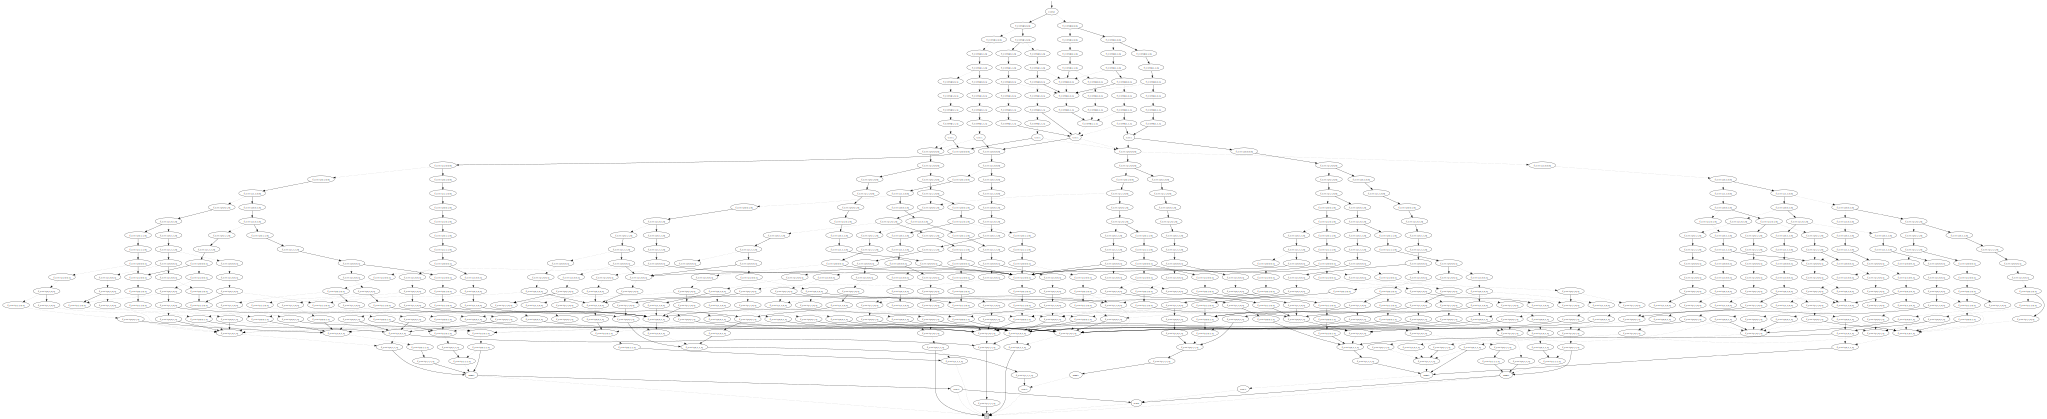

In [9]:
import graphviz
graphviz.Source(reachable.to_bdd().to_dot())